# AUTOENCODERS
In this notebook, we are going to write a code and train the model for autoencoder, it consists of two things, one is encoder and other is decoder.  
  Encoder encodes image => latent space, while decoder takes values of latent space to reconstruct it to image.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras import layers, models, datasets, callbacks
import tensorflow.keras.backend as K

In [2]:
## showing images from dataset
def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

In [3]:
# parameters
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 3

In [4]:
# preparing the data
(X_train,y_train),(X_test,y_test) = datasets.fashion_mnist.load_data()

In [9]:
def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


X_train = preprocess(X_train)
X_test = preprocess(X_test)

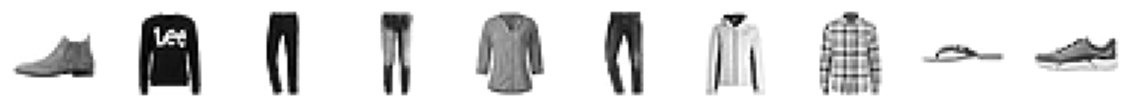

In [11]:
display(X_test)

# Encoder Model

In [14]:
encoder_input = layers.Input(shape = (IMAGE_SIZE,IMAGE_SIZE,CHANNELS),name = "encoder_input")
x = layers.Conv2D(32,(3,3),strides=2,activation="relu",padding="same")(encoder_input)
x = layers.Conv2D(64,(3,3),strides=2,activation="relu",padding="same")(x)
x = layers.Conv2D(128,(3,3),strides=2,activation="relu",padding="same")(x)

shape_before_flattening = K.int_shape(x)[1:]#used in decoder

x = layers.Flatten()(x)

encoder_output = layers.Dense(EMBEDDING_DIM, name = "encoder_output")(x)

#model rep
encoder = models.Model(encoder_input,encoder_output)
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
encoder_output (Dense)       (None, 2)                 4098      
Total params: 96,770
Trainable params: 96,770
Non-trainable params: 0
_________________________________________________________

# Decoder Model

In [17]:
decoder_input = layers.Input(shape = (EMBEDDING_DIM,),name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)

x = layers.Conv2DTranspose(128,(3,3),strides=2,activation="relu",padding="same")(x)
x = layers.Conv2DTranspose(64,(3,3),strides=2,activation="relu",padding="same")(x)
x = layers.Conv2DTranspose(32,(3,3),strides=2,activation="relu",padding="same")(x)
decoder_output = layers.Conv2D(CHANNELS,(3,3),strides=1,activation="sigmoid",padding="same",name="decoder_output")(x)

decoder = models.Model(decoder_input,decoder_output)
decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              6144      
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 8, 8, 128)         147584    
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 16, 16, 64)        73792     
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 32, 32, 32)        18464     
_________________________________________________________________
decoder_output (Conv2D)      (None, 32, 32, 1)         289 

# AutoEncoder
we construct autoencoder from adding encoder and decoder together.

In [19]:
autoencoder = models.Model(encoder_input,decoder(encoder_output))

autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
encoder_output (Dense)       (None, 2)                 4098      
_________________________________________________________________
model_1 (Model)              (None, 32, 32, 1)         2462

# train the autoencoder

In [24]:
autoencoder.compile(optimizer="adam",loss = "mse")

In [29]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)

In [30]:
autoencoder.fit(
    X_train,
    X_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(X_test, X_test),
    callbacks=[model_checkpoint_callback],
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 171s 3ms/sample - loss: 0.0246 - val_loss: 0.0236
Epoch 2/3
60000/60000 [==============================] - 190s 3ms/sample - loss: 0.0234 - val_loss: 0.0230
Epoch 3/3
60000/60000 [==============================] - 186s 3ms/sample - loss: 0.0227 - val_loss: 0.0224


In [31]:
autoencoder.save("models\\autoencoder")
encoder.save("models\\encoder")
decoder.save("models\\decoder")

INFO:tensorflow:Assets written to: models\autoencoder\assets
INFO:tensorflow:Assets written to: models\encoder\assets
INFO:tensorflow:Assets written to: models\decoder\assets


# Reconstruct new images from autoencoder

Example real clothing items


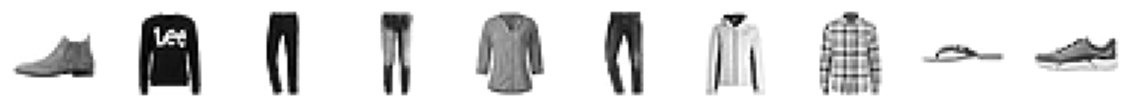

Reconstructions


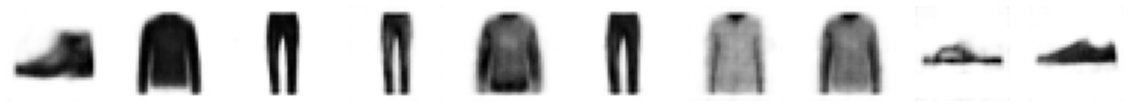

In [34]:
predictions = autoencoder.predict(X_test)

print("Example real clothing items")
display(X_test)
print("Reconstructions")
display(predictions)

# Encoder encoded values

In [37]:
embeddings = encoder.predict(X_test)
print(embeddings[:10])

[[-0.87173545 -1.9372302 ]
 [ 5.56058    -2.6021535 ]
 [ 3.619205    4.796513  ]
 [ 1.6430156   2.5623212 ]
 [ 2.298745   -1.5657424 ]
 [ 3.2578552   3.4705045 ]
 [ 1.2554163  -0.33988518]
 [ 2.0324817  -0.9887892 ]
 [-1.84114    -0.1741719 ]
 [-3.136956   -1.5340801 ]]


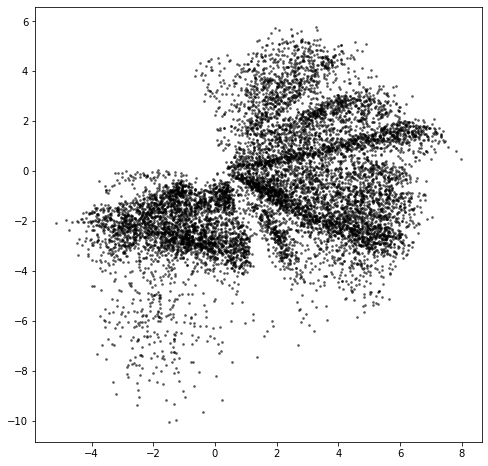

In [38]:
figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

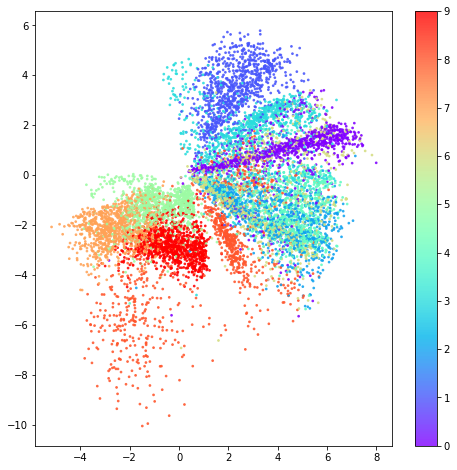

In [39]:
# Colour the embeddings by their label (clothing type - see table)
example_labels = y_test

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

# Genrating new data from decoder

In [43]:
# Get the range of the existing embeddings
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# Sample some points in the latent space
grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM)
)

In [44]:
# Decode the sampled points
reconstructions = decoder.predict(sample)

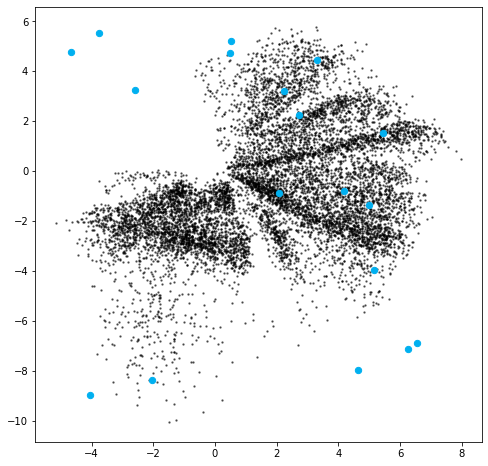

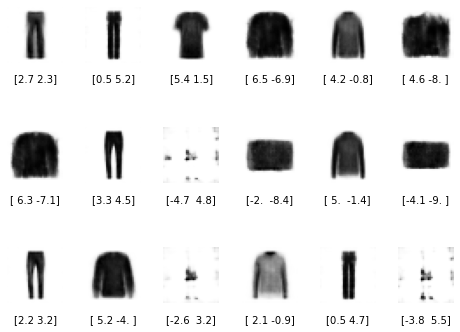

In [45]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")